# Classify audio effects on guitar samples

## 0. Import and config

In [29]:
import os
import time
import numpy as np
import pandas as pd
import scipy
import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as ms
ms.use('seaborn-muted')
import IPython.display as Ipd
import sklearn
from joblib import dump, load

In [47]:
# Setup variables
samplerate = 44100
sample_len = 2*samplerate
n_mfcc = 13
hop_len = 512
segment_len = int(np.ceil(sample_len/hop_len))
mfcc_len = segment_len
spectral_bandwidth_len = segment_len
spectral_flatness_len = 0
feature_len = mfcc_len*n_mfcc + spectral_bandwidth_len + spectral_flatness_len
feature_reduced_len = mfcc_len*2 + spectral_bandwidth_len + spectral_flatness_len
print("Full feature size: %i" % feature_len)
print("Reduced feature size: %i" % feature_reduced_len)

Full feature size: 2422
Reduced feature size: 519


## 1. Import and prepare data

In [48]:
#get audio files
fileswchorus = os.listdir('./DataSet/Samples/Chorus')
fileswdistortion = os.listdir('./DataSet/Samples/Distortion')
filesweq = os.listdir('./DataSet/Samples/EQ')
fileswdelay = os.listdir('./DataSet/Samples/FeedbackDelay')
fileswflanger = os.listdir('./DataSet/Samples/Flanger')
fileswnofx = os.listdir('./DataSet/Samples/NoFX')

#calc number of samples
n_data = len(fileswchorus)+len(fileswdistortion)+len(filesweq)+len(fileswdelay)+len(fileswflanger)+len(fileswnofx)
print("Number of samples: %i" % n_data)

#setup classes
labels = np.zeros(n_data)
features_full = np.zeros((n_data, feature_len))
features_reduced = np.zeros((n_data, feature_reduced_len))
classes = ['Chorus','Distortion','EQ','FeedbackDelay','Flanger','NoFX']

Number of samples: 9360


## 2.a Extract features

### Extract full MFCCs, spectral bandwidth, and spectral flatness

In [50]:
from IPython.display import clear_output
start_time = time.time()
count = 0

def extract_features(filename, count=0):
    signal, dummy = librosa.load(filename, samplerate, mono=True)
    mfccs = librosa.feature.mfcc(signal, samplerate, n_mfcc=n_mfcc, hop_length=hop_len).flatten()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(signal, samplerate).flatten()
    #spectral_flatness = np.mean(librosa.feature.spectral_flatness(signal).flatten())
    #output = np.append(np.concatenate((mfccs, spectral_bandwidth)),spectral_flatness)
    output = np.concatenate((mfccs, spectral_bandwidth))
    clear_output(wait=True)
    print("%i/%i samples processed" % (count, n_data))
    return output
    
idx = 0
    
for x in fileswchorus:
    count = count+1
    output = extract_features('./DataSet/Samples/Chorus/' + x, count)
    features_full[idx,:] = output
    labels[idx] = 0
    idx = idx+1
    
for x in fileswdistortion:
    count = count+1
    output = extract_features('./DataSet/Samples/Distortion/' + x, count)
    features_full[idx,:] = output
    labels[idx] = 1
    idx = idx+1    
        
for x in filesweq:
    count = count+1
    output = extract_features('./DataSet/Samples/EQ/' + x, count)
    features_full[idx,:] = output
    labels[idx] = 2
    idx = idx+1    
    
for x in fileswdelay:
    count = count+1
    output = extract_features('./DataSet/Samples/FeedbackDelay/' + x, count)
    features_full[idx,:] = output
    labels[idx] = 3
    idx = idx+1    

for x in fileswflanger:
    count = count+1
    output = extract_features('./DataSet/Samples/Flanger/' + x, count)
    features_full[idx,:] = output
    labels[idx] = 4
    idx = idx+1    

for x in fileswnofx:
    count = count+1
    output = extract_features('./DataSet/Samples/NoFX/' + x, count)
    features_full[idx,:] = output
    labels[idx] = 5
    idx = idx+1    

print("Feature extraction done")
print("Took %d seconds" % (time.time() - start_time))

9360/9360 samples processed
Feature extraction done
Took 295 seconds


### Extract MFCC mean and variance, spectral bandwidth, and spectral flatness

In [51]:
from IPython.display import clear_output
start_time = time.time()
count = 0

def extract_features(filename, count=0):
    signal, dummy = librosa.load(filename, samplerate, mono=True)
    mfccs = librosa.feature.mfcc(signal, samplerate, n_mfcc=n_mfcc, hop_length=hop_len)
    mfccs_mean = np.mean(mfccs,0).flatten()
    mfccs_std = np.std(mfccs,0).flatten()
    spec_band = librosa.feature.spectral_bandwidth(signal, samplerate).flatten()
    #spec_flatness = np.mean(librosa.feature.spectral_flatness(signal).flatten())
    #output = np.append(np.concatenate((mfccs_mean, mfccs_std, spec_band)),spec_flatness)
    output = np.concatenate((mfccs_mean, mfccs_std, spec_band))
    clear_output(wait=True)
    print("%i/%i samples processed" % (count, n_data))
    return output
    
idx = 0
    
for x in fileswchorus:
    count = count+1
    output = extract_features('./DataSet/Samples/Chorus/' + x, count)
    features_reduced[idx,:] = output
    labels[idx] = 0
    idx = idx+1
    
for x in fileswdistortion:
    count = count+1
    output = extract_features('./DataSet/Samples/Distortion/' + x, count)
    features_reduced[idx,:] = output
    labels[idx] = 1
    idx = idx+1    
        
for x in filesweq:
    count = count+1
    output = extract_features('./DataSet/Samples/EQ/' + x, count)
    features_reduced[idx,:] = output
    labels[idx] = 2
    idx = idx+1    
    
for x in fileswdelay:
    count = count+1
    output = extract_features('./DataSet/Samples/FeedbackDelay/' + x, count)
    features_reduced[idx,:] = output
    labels[idx] = 3
    idx = idx+1    

for x in fileswflanger:
    count = count+1
    output = extract_features('./DataSet/Samples/Flanger/' + x, count)
    features_reduced[idx,:] = output
    labels[idx] = 4
    idx = idx+1    

for x in fileswnofx:
    count = count+1
    output = extract_features('./DataSet/Samples/NoFX/' + x, count)
    features_reduced[idx,:] = output
    labels[idx] = 5
    idx = idx+1    

print("Feature extraction done")
print("Took %d seconds" % (time.time() - start_time))

9360/9360 samples processed
Feature extraction done
Took 295 seconds


### Save labels in pandas object

In [6]:
labels = pd.DataFrame(labels)
labels.columns = ['labels']
labels = labels['labels']

### Save features to .csv - Full features

In [7]:
dataset = pd.DataFrame(features_full)
column_names = []
for c in range(feature_len):
    column_names.append("Feat %i" % c)
dataset.columns =  column_names
dataset['label digit'] = labels
label_text = []
for l in labels:
    label_text.append(classes[int(l)])
dataset['label text'] = label_text
dataset.to_csv('features_full.csv')
dataset

,Feat 0,Feat 1,Feat 2,Feat 3,Feat 4,Feat 5,Feat 6,Feat 7,Feat 8,Feat 9,...,Feat 2415,Feat 2416,Feat 2417,Feat 2418,Feat 2419,Feat 2420,Feat 2421,Feat 2422,label digit,label text
0,-805.815063,-805.815063,-805.815063,-805.815063,-805.815063,-805.815063,-804.980103,-801.050720,-801.329163,-801.926819,...,2246.046469,2418.996250,2634.657126,2932.928664,3498.321297,4201.152815,4640.851434,0.033446,0.0,Chorus
1,-772.046570,-772.046570,-772.046570,-772.046570,-772.046570,-772.046570,-772.046570,-770.233826,-769.957703,-769.533997,...,2131.864846,2369.619799,2605.466591,2939.137964,3435.068893,4179.774120,4721.955989,0.033872,0.0,Chorus
2,-764.198669,-764.198669,-764.198669,-764.198669,-764.198669,-764.198669,-764.198669,-762.892944,-763.503723,-762.692322,...,2189.081994,2340.093213,2506.136772,2774.008847,3239.473929,3982.139098,4670.631257,0.034967,0.0,Chorus
3,-782.452148,-782.452148,-782.452148,-782.452148,-782.452148,-782.452148,-782.452148,-782.452148,-782.452148,-782.452148,...,2636.239590,2857.767980,3087.833133,3444.860760,4021.266627,4497.147804,4627.044415,0.044314,0.0,Chorus
4,-767.481506,-767.481506,-767.481506,-767.481506,-767.481506,-767.481506,-767.481506,-767.481506,-767.481506,-767.481506,...,2662.748375,2928.491952,3121.173055,3497.104808,4091.195166,4540.594038,4711.831888,0.046354,0.0,Chorus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9355,-841.291992,-841.291992,-841.291992,-841.291992,-841.291992,-841.291992,-841.291992,-841.291992,-841.291992,-841.291992,...,4780.038563,5137.903350,5481.891117,5936.500631,6349.154289,6598.279974,6318.066195,0.180398,5.0,NoFX
9356,-848.435181,-848.435181,-848.435181,-848.435181,-848.435181,-848.435181,-848.435181,-848.435181,-848.435181,-848.435181,...,5417.428686,5667.315640,5845.391073,6348.099061,6816.736924,6670.926386,6233.212061,0.188355,5.0,NoFX
9357,-849.316956,-849.316956,-849.316956,-849.316956,-849.316956,-849.316956,-849.316956,-849.316956,-849.316956,-849.316956,...,5647.541131,5992.078540,6307.800786,6578.655490,6691.608145,6512.613365,6257.745159,0.188150,5.0,NoFX
9358,-834.982605,-834.982605,-834.982605,-834.982605,-834.982605,-834.982605,-834.982605,-834.982605,-834.982605,-834.982605,...,5753.728200,6031.078789,6561.493139,7042.708430,6990.960488,6565.114083,6228.771383,0.209479,5.0,NoFX


### Save features to .csv - Reduced features

In [8]:
dataset = pd.DataFrame(features_reduced)
column_names = []
for c in range(feature_reduced_len):
    column_names.append("Feat %i" % c)
dataset.columns =  column_names
dataset['label digit'] = labels
label_text = []
for l in labels:
    label_text.append(classes[int(l)])
dataset['label text'] = label_text
dataset.to_csv('features_reduced.csv')
dataset

,Feat 0,Feat 1,Feat 2,Feat 3,Feat 4,Feat 5,Feat 6,Feat 7,Feat 8,Feat 9,...,Feat 512,Feat 513,Feat 514,Feat 515,Feat 516,Feat 517,Feat 518,Feat 519,label digit,label text
0,-61.985775,-61.985775,-61.985775,-61.985775,-61.985775,-61.985775,-61.072880,-57.283871,-56.725319,-57.024776,...,2246.046469,2418.996250,2634.657126,2932.928664,3498.321297,4201.152815,4640.851434,0.033446,0.0,Chorus
1,-59.388199,-59.388199,-59.388199,-59.388199,-59.388199,-59.388199,-59.388199,-57.196560,-56.676338,-56.019588,...,2131.864846,2369.619799,2605.466591,2939.137964,3435.068893,4179.774120,4721.955989,0.033872,0.0,Chorus
2,-58.784512,-58.784512,-58.784512,-58.784512,-58.784512,-58.784512,-58.784512,-57.435303,-58.013515,-57.281395,...,2189.081994,2340.093213,2506.136772,2774.008847,3239.473929,3982.139098,4670.631257,0.034967,0.0,Chorus
3,-60.188625,-60.188625,-60.188625,-60.188625,-60.188625,-60.188625,-60.188625,-60.188625,-60.188625,-60.188625,...,2636.239590,2857.767980,3087.833133,3444.860760,4021.266627,4497.147804,4627.044415,0.044314,0.0,Chorus
4,-59.037041,-59.037041,-59.037041,-59.037041,-59.037041,-59.037041,-59.037041,-59.037041,-59.037041,-59.037041,...,2662.748375,2928.491952,3121.173055,3497.104808,4091.195166,4540.594038,4711.831888,0.046354,0.0,Chorus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9355,-64.714767,-64.714767,-64.714767,-64.714767,-64.714767,-64.714767,-64.714767,-64.714767,-64.714767,-64.714767,...,4780.038563,5137.903350,5481.891117,5936.500631,6349.154289,6598.279974,6318.066195,0.180398,5.0,NoFX
9356,-65.264244,-65.264244,-65.264244,-65.264244,-65.264244,-65.264244,-65.264244,-65.264244,-65.264244,-65.264244,...,5417.428686,5667.315640,5845.391073,6348.099061,6816.736924,6670.926386,6233.212061,0.188355,5.0,NoFX
9357,-65.332077,-65.332077,-65.332077,-65.332077,-65.332077,-65.332077,-65.332077,-65.332077,-65.332077,-65.332077,...,5647.541131,5992.078540,6307.800786,6578.655490,6691.608145,6512.613365,6257.745159,0.188150,5.0,NoFX
9358,-64.229431,-64.229431,-64.229431,-64.229431,-64.229431,-64.229431,-64.229431,-64.229431,-64.229431,-64.229431,...,5753.728200,6031.078789,6561.493139,7042.708430,6990.960488,6565.114083,6228.771383,0.209479,5.0,NoFX


### Select feature set to use

In [36]:
# Feature switch
#features = features_reduced
features = features_full
print(features.shape)

(9360, 2423)


In [37]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.2, random_state=7)

In [38]:
#learning the scaling transformation from the train data and applying it to both train and test set.

#creating scaling object
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling from train set
scaler.fit(feat_train)

#applying scaling to both train and test set
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

## Dimensionality reduction

(9360, 5)


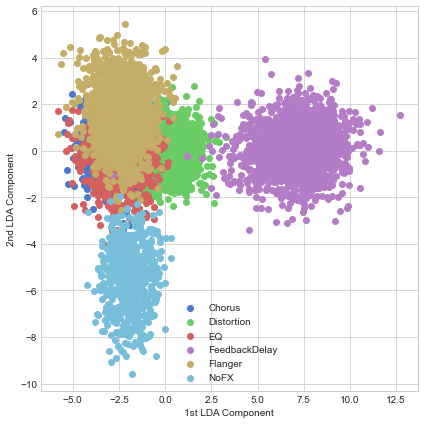

In [39]:
#Creating an instance of the LDA object, which is an object capable of learning and applying LDA from/to data.
#if we want to keep only a given number of components we can use the argument "n_components"
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()


#LDA needs BOTH features and labels (as numbers), other techniques needs only features
lda.fit(features, labels)

#Now we project the data into a from a 7D to a (number of classes - 1) space,
#if the number of components in scikit-learn, LDA transform the data to a number of dimensions
#equal to min(n_classes - 1), which in our case is 4 classes -1 = 3.
#with more classess we will have more dimensions at the output of LDA projection
projected_features = lda.transform(features)

#the dimensionality should be the same number of classes - 1
print(projected_features.shape)

#Plot the distribution of the data according to the first two LDA components
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 6))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 1],
                    projected_features[labels==lab_val, 2],
                    label=lab_name)
    plt.xlabel('1st LDA Component')
    plt.ylabel('2nd LDA Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

In [40]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
proj_feat_train, proj_feat_test, lab_train, lab_test = train_test_split(projected_features, labels, test_size=0.2, random_state=7)

## SVM Classifier 

In [14]:
#Creating an instance of a SVM classifier
model_SVM = sklearn.svm.SVC(kernel='rbf', C=2.0, verbose=True)

#training the model
model_SVM.fit(proj_feat_train, lab_train)

#applying the the model on the test data (features)
lab_predict = model_SVM.predict(proj_feat_test)

#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

[LibSVM]Number of mislabeled samples 242 out of 1872
Accuracy: 0.8707264957264957


              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77       377
         1.0       1.00      1.00      1.00       391
         2.0       0.78      0.82      0.80       242
         3.0       1.00      0.99      0.99       363
         4.0       0.77      0.72      0.75       378
         5.0       0.91      0.95      0.93       121

    accuracy                           0.87      1872
   macro avg       0.87      0.88      0.87      1872
weighted avg       0.87      0.87      0.87      1872



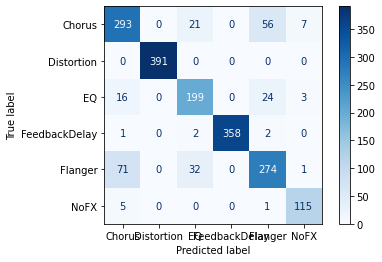

In [15]:
#computing a comprehensive set of performance metrics
print(sklearn.metrics.classification_report(lab_test, lab_predict))

disp = sklearn.metrics.plot_confusion_matrix(model_SVM, proj_feat_test, lab_test, display_labels=classes, cmap=plt.cm.Blues, normalize=None)

## ANN Classifier

### No dimensionality reduction 

Accuracy: 0.9230769230769231


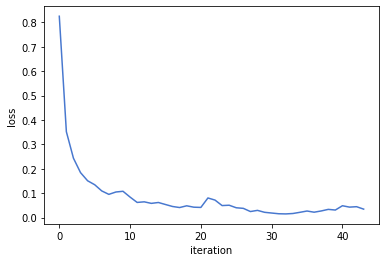

Number of mislabeled samples 144 out of 1872
Accuracy: 0.9230769230769231
              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82       377
         1.0       1.00      1.00      1.00       391
         2.0       0.95      0.94      0.94       242
         3.0       0.99      0.97      0.98       363
         4.0       0.83      0.89      0.86       378
         5.0       0.99      0.97      0.98       121

    accuracy                           0.92      1872
   macro avg       0.93      0.93      0.93      1872
weighted avg       0.92      0.92      0.92      1872



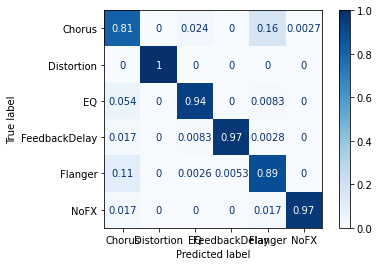

In [41]:
#Import the classifier
from sklearn.neural_network import MLPClassifier

##Creating an instance of a MLP classifier
#and setting it some option (max mum epoch, verbose on, activation of neurons)
mlp = MLPClassifier(hidden_layer_sizes=(100,50,100), max_iter=10000, activation='relu', verbose=False)

#train the model
mlp.fit(feat_train, lab_train)

#applying the the model on the test data (features)
lab_predict = mlp.predict(feat_test)
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

#plotting the loss curve over training iteration 
plt.plot(mlp.loss_curve_)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))
print(sklearn.metrics.classification_report(lab_test, lab_predict))
disp = sklearn.metrics.plot_confusion_matrix(mlp, feat_test, lab_test, display_labels=classes, cmap=plt.cm.Blues, normalize="true")

In [42]:
# Save the model
dump(mlp, 'mlp.joblib')

['mlp.joblib']

### With dimensionality reduction

Accuracy: 0.9711538461538461


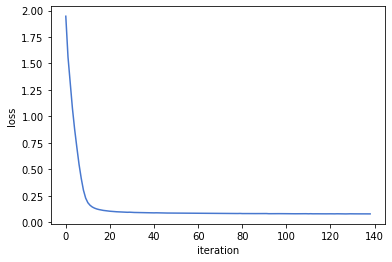

Number of mislabeled samples 54 out of 1872
Accuracy: 0.9711538461538461
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       377
         1.0       1.00      1.00      1.00       391
         2.0       0.96      1.00      0.98       242
         3.0       1.00      1.00      1.00       363
         4.0       0.96      0.92      0.94       378
         5.0       0.99      0.98      0.99       121

    accuracy                           0.97      1872
   macro avg       0.97      0.97      0.97      1872
weighted avg       0.97      0.97      0.97      1872



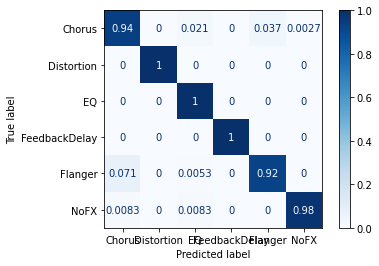

In [43]:
#Import the classifier
from sklearn.neural_network import MLPClassifier

##Creating an instance of a MLP classifier
#and setting it some option (max mum epoch, verbose on, activation of neurons)
mlp = MLPClassifier(hidden_layer_sizes=(10,5,10), max_iter=10000, activation='relu', verbose=False)

#train the model
mlp.fit(proj_feat_train, lab_train)

#applying the the model on the test data (features)
lab_predict = mlp.predict(proj_feat_test)
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

#plotting the loss curve over training iteration 
plt.plot(mlp.loss_curve_)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))
print(sklearn.metrics.classification_report(lab_test, lab_predict))
disp = sklearn.metrics.plot_confusion_matrix(mlp, proj_feat_test, lab_test, display_labels=classes, cmap=plt.cm.Blues, normalize="true")

In [44]:
# Save the model
dump(mlp, 'mlp_lda.joblib')

['mlp_lda.joblib']

In [18]:
#displaying names of misclassified files
results = lab_test == lab_predict

for index, value in results.items():
    if value == False:
        print(classes[int(lab_test[index])])

Chorus
Chorus
Flanger
EQ
EQ
Chorus
Chorus
Flanger
Chorus
Chorus
Chorus
Chorus
Flanger
Flanger
Flanger
Flanger
Chorus
Flanger
Chorus
Flanger
EQ
EQ
Chorus
Chorus
Chorus
Flanger
Flanger
Chorus
Chorus
Chorus
Chorus
Flanger
Flanger
Flanger
Flanger
Chorus
Flanger
Flanger
Flanger
Flanger
Chorus
Chorus
Chorus
Chorus
Flanger
Flanger
Flanger
Chorus
Chorus
Flanger
Chorus
Chorus
Chorus
EQ
Chorus
EQ
Flanger
Flanger
Flanger
EQ
Flanger
Chorus
Flanger
Flanger
EQ
Chorus
Flanger
Flanger
Flanger
Chorus
Flanger
EQ
Flanger
Chorus
Chorus
Flanger
Chorus
FeedbackDelay
Flanger
EQ
Chorus
Flanger
Chorus
FeedbackDelay
Flanger
Flanger
Flanger
NoFX
EQ
EQ
Chorus
Chorus
Chorus
EQ
Flanger
Flanger
Flanger
Chorus
Chorus
Chorus
Chorus
Chorus
NoFX
Chorus
Chorus
Chorus
EQ
EQ
Chorus
Chorus
EQ
Chorus
Flanger
Flanger
Chorus
Flanger
Flanger
EQ
Chorus
EQ
Flanger
EQ
NoFX
Chorus
Flanger
Chorus
Chorus
Flanger
Chorus
Chorus
Flanger
Chorus
Chorus
EQ
Flanger
Flanger
EQ
Flanger
Flanger
NoFX
EQ
EQ
Flanger
Flanger
EQ
Chorus
Flanger
Chor

# K-Fold Cross Validation
### No dimensionality reduction

In [25]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
pipe = Pipeline([('scaler', StandardScaler()),
                 ('classifier', MLPClassifier(hidden_layer_sizes=(100,50,100), max_iter=10000, activation='relu', verbose=False))
                ])

skf = sklearn.model_selection.StratifiedKFold()
scores = sklearn.model_selection.cross_validate(pipe, features, labels, cv=skf, scoring=('f1_macro', 'accuracy'), return_train_score=True)

print(scores,'\n')
print('Accuracy mean and variance', np.mean(scores['test_accuracy']),np.var(scores['test_accuracy']),'\n')
print('F1 macro mean and variance', np.mean(scores['test_f1_macro']),np.var(scores['test_f1_macro']),'\n')

{'fit_time': array([11.64825845, 12.03796816, 15.96199989, 14.36502481, 11.57219172]), 'score_time': array([0.01401091, 0.01902938, 0.01700163, 0.01497579, 0.01500607]), 'test_f1_macro': array([0.90664411, 0.87783914, 0.92959984, 0.8934117 , 0.91270852]), 'train_f1_macro': array([0.99449059, 0.98867455, 0.99515934, 0.99599431, 0.98139877]), 'test_accuracy': array([0.90224359, 0.88194444, 0.9284188 , 0.89262821, 0.90972222]), 'train_accuracy': array([0.9934562 , 0.98838141, 0.99425748, 0.99519231, 0.97956731])} 

Accuracy mean and variance 0.902991452991453 0.00024855723573672316 

F1 macro mean and variance 0.9040406604750544 0.00030693519949631616 



### With dimensionality reduction

In [26]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lda', LinearDiscriminantAnalysis()),
                 ('classifier', MLPClassifier(hidden_layer_sizes=(10,5,10), max_iter=10000, activation='relu', verbose=False))
                ])

skf = sklearn.model_selection.StratifiedKFold()
scores = sklearn.model_selection.cross_validate(pipe, features, labels, cv=skf, scoring=('f1_macro', 'accuracy'), return_train_score=True)

print(scores,'\n')
print('Accuracy mean and variance', np.mean(scores['test_accuracy']),np.var(scores['test_accuracy']),'\n')
print('F1 macro mean and variance', np.mean(scores['test_f1_macro']),np.var(scores['test_f1_macro']),'\n')

{'fit_time': array([5.41410279, 6.22700357, 5.29600024, 4.84403276, 5.00803161]), 'score_time': array([0.01300144, 0.01502776, 0.01300025, 0.01300049, 0.01300025]), 'test_f1_macro': array([0.84125559, 0.84599382, 0.84788078, 0.76910783, 0.82259576]), 'train_f1_macro': array([0.88450549, 0.88274454, 0.88368566, 0.89867808, 0.88501039]), 'test_accuracy': array([0.8349359 , 0.84882479, 0.84401709, 0.78418803, 0.83279915]), 'train_accuracy': array([0.8815438 , 0.87873932, 0.87967415, 0.89396368, 0.88087607])} 

Accuracy mean and variance 0.8289529914529915 0.0005352609759661043 

F1 macro mean and variance 0.8253667561408429 0.0008715113461761397 



## Repeated K-Fold Cross Validation
### No dimensionality reduction

In [45]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
pipe = Pipeline([('scaler', StandardScaler()),
                 ('classifier', MLPClassifier(hidden_layer_sizes=(100,50,100), max_iter=10000, activation='relu', verbose=False))
                ])

rskf = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
scores = sklearn.model_selection.cross_validate(pipe, features, labels, cv=rskf, scoring=('f1_macro', 'accuracy'), return_train_score=True)

print(scores,'\n')
print('Accuracy mean and variance', np.mean(scores['test_accuracy']),np.var(scores['test_accuracy']),'\n')
print('F1 macro mean and variance', np.mean(scores['test_f1_macro']),np.var(scores['test_f1_macro']),'\n')

{'fit_time': array([58.48262239, 22.89378238, 50.75854683, 42.93044019, 45.75104427,
       32.08476114, 46.57875371, 35.32995129, 35.29930663, 42.932621  ,
       30.40724897, 44.29231286, 52.55554461, 41.17655039, 47.98828268,
       48.47355938, 46.35277057, 30.37194777, 40.79603934, 35.92968607,
       31.77086997, 36.12323427, 26.31376982, 33.62151241, 34.5164547 ,
       41.10213161, 46.61270738, 33.60647106, 28.99361706, 59.14847589,
       63.44520283, 37.74767733, 20.85164666, 30.23948836, 39.74864841,
       30.94360375, 34.96383476, 21.63551831, 41.40681934, 46.24839091,
       45.95198107, 39.15393448, 27.54847169, 26.86861062, 43.0502491 ,
       30.33592176, 28.90230751, 28.34166956, 21.47729826, 31.5816431 ]), 'score_time': array([0.05897379, 0.05403495, 0.05299973, 0.05400372, 0.0559988 ,
       0.048002  , 0.06900263, 0.05100131, 0.05600095, 0.05003262,
       0.05200672, 0.05002737, 0.05400085, 0.05200481, 0.05400109,
       0.05000257, 0.05400133, 0.0519731 , 0.05499

### With dimensionality reduction

In [46]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lda', LinearDiscriminantAnalysis()),
                 ('classifier', MLPClassifier(hidden_layer_sizes=(10,5,10), max_iter=10000, activation='relu', verbose=False))
                ])

rskf = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
scores = sklearn.model_selection.cross_validate(pipe, features, labels, cv=rskf, scoring=('f1_macro', 'accuracy'), return_train_score=True)

print(scores,'\n')
print('Accuracy mean and variance', np.mean(scores['test_accuracy']),np.var(scores['test_accuracy']),'\n')
print('F1 macro mean and variance', np.mean(scores['test_f1_macro']),np.var(scores['test_f1_macro']),'\n')

{'fit_time': array([19.60348964, 20.48412156, 18.76431489, 18.90899777, 19.80510402,
       19.32179713, 20.62287784, 20.61800337, 19.81042671, 20.16814184,
       19.9134717 , 21.13819408, 19.85547924, 20.1471231 , 19.43982482,
       19.10730624, 18.90543127, 19.12899876, 19.0729723 , 18.73545265,
       20.27075934, 18.95387745, 18.80903172, 18.81503248, 19.93803596,
       20.55210757, 18.74975991, 18.87400198, 19.26803017, 18.88015151,
       19.80503273, 18.55105782, 18.96599913, 18.96113753, 19.34376168,
       18.85258198, 18.54443932, 20.65329027, 19.68007874, 21.13003087,
       19.11135244, 19.3955195 , 19.7272613 , 19.59879017, 19.24000359,
       18.4282949 , 19.30749488, 18.73061991, 19.79096055, 18.91766715]), 'score_time': array([0.05699444, 0.05599594, 0.05599499, 0.0579989 , 0.0559988 ,
       0.05700541, 0.06596875, 0.0570035 , 0.0569725 , 0.05999875,
       0.05699587, 0.05599952, 0.05700016, 0.05600023, 0.05599737,
       0.05599999, 0.05702734, 0.05599952, 0.05599

## Grid search

### SVM parameter search

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lda', LinearDiscriminantAnalysis()),
                 ('classifier', SVC())])

rskf = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
grid_params = {
    'classifier__C':[1,3,5]
}

grid_search = sklearn.model_selection.GridSearchCV(estimator=pipe, param_grid=grid_params, scoring='accuracy', cv=rskf, n_jobs=-1)
grid_search.fit(features,labels)

print('best set of parameters', grid_search.best_params_)
print('associated best score',grid_search.best_score_)      

### MLP parameter search

In [ ]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pipe = Pipeline([('scaler', StandardScaler()),
                 #('lda', LinearDiscriminantAnalysis()),
                 ('classifier', MLPClassifier(hidden_layer_sizes=(10,5,10), max_iter=10000, activation='relu'))
                ])

rskf = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
grid_params = {
    'classifier__hidden_layer_sizes':[(10,5,10),(100,50,100),(1000,500,1000)]
}
                                                       
grid_search = sklearn.model_selection.GridSearchCV(estimator=pipe, param_grid=grid_params, scoring='accuracy',cv=rskf,n_jobs=-1)
grid_search.fit(features, labels)
                                                       
print('best set of parameters', grid_search.best_params_)
print('associated best score',grid_search.best_score_)                                                       
                                                       